# Fitness Classifiction Data

In [29]:
# Importing Libraries
%pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
# Loading dataset
df = pd.read_csv('fitness_class_2212.csv')  

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (1500, 8)

First 5 Rows:


,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


## Missing data

In [58]:
# Check for missing data
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64


In [59]:
# Handling missing data
# Impute missing values 
imputer = SimpleImputer(strategy='mean')
df['weight'] = imputer.fit_transform(df[['weight']])

## Exploratory Data Analysis

In [60]:
df.describe()

,booking_id,months_as_member,weight,attended
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,15.628667,82.610378,0.302667
std,433.157015,12.926543,12.680411,0.459565
min,1.000000,1.000000,55.410000,0.000000
25%,375.750000,8.000000,73.562500,0.000000
50%,750.500000,12.000000,81.035000,0.000000
75%,1125.250000,19.000000,89.382500,1.000000
max,1500.000000,148.000000,170.520000,1.000000


In [61]:
# Unique values in the target variable
df['attended'].unique()

array([0, 1], dtype=int64)

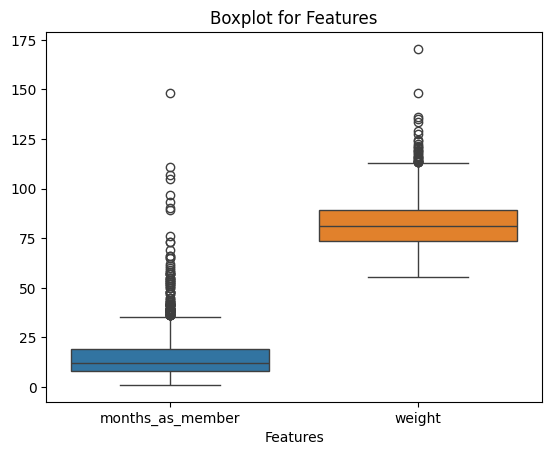

In [62]:
# Boxplot of the numeric features
sns.boxplot(data=df.drop(['booking_id','attended'], axis=1))   # Removed the booking ID and attented variables
plt.title('Boxplot for Features')
plt.xlabel('Features')
plt.show()

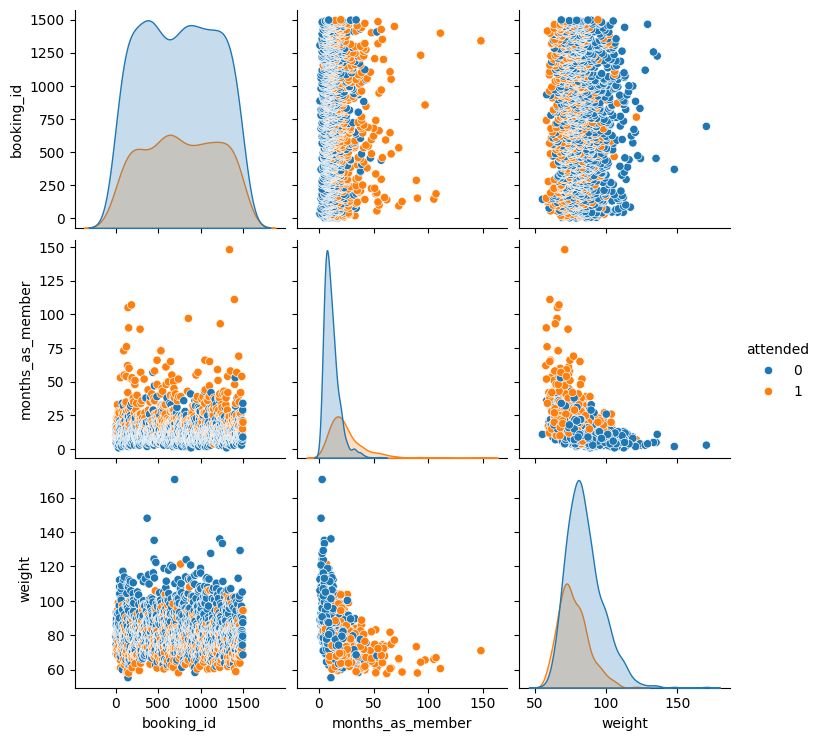

In [63]:
# Pairplot using the target variable as the hue
sns.pairplot(data=df, hue='attended')

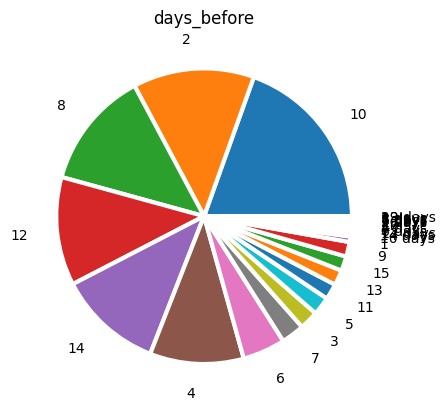

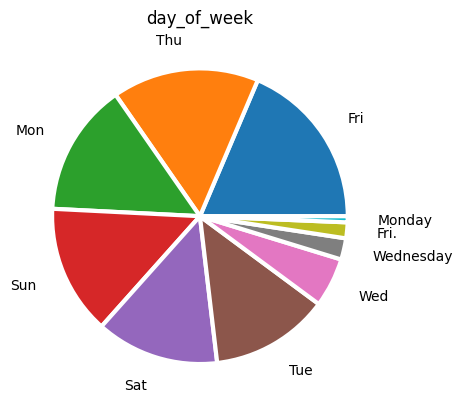

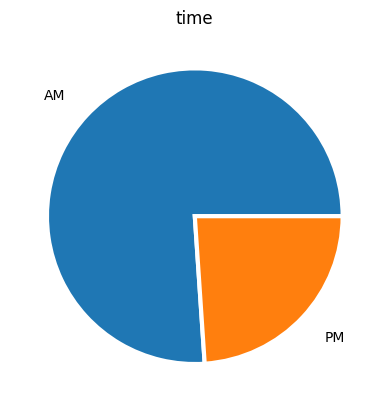

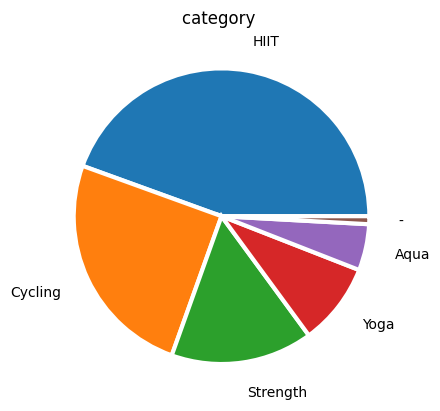

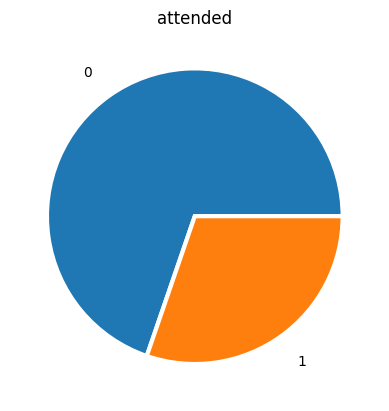

In [64]:
# Pie chart for categorical data 
# days_before
days_before_count = df['days_before'].value_counts()
plt.pie(days_before_count.values, labels=days_before_count.index, labeldistance=1.2,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('days_before')
plt.show()


# day_of_week     
day_of_week_count = df['day_of_week'].value_counts()
plt.pie(day_of_week_count.values, labels=day_of_week_count.index, labeldistance=1.2,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('day_of_week')
plt.show()


# time 
time_count = df['time'].value_counts()
plt.pie(time_count.values, labels=time_count.index, labeldistance=1.2,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('time')
plt.show()

# category 
category_count = df['category'].value_counts()
plt.pie(category_count.values, labels=category_count.index, labeldistance=1.2,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('category ')
plt.show()

# attended
attended_count = df['attended'].value_counts()
plt.pie(attended_count.values, labels=attended_count.index, labeldistance=1.2,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('attended')
plt.show()  

## Preprocessing

### Label encoding

In [38]:
# Label encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

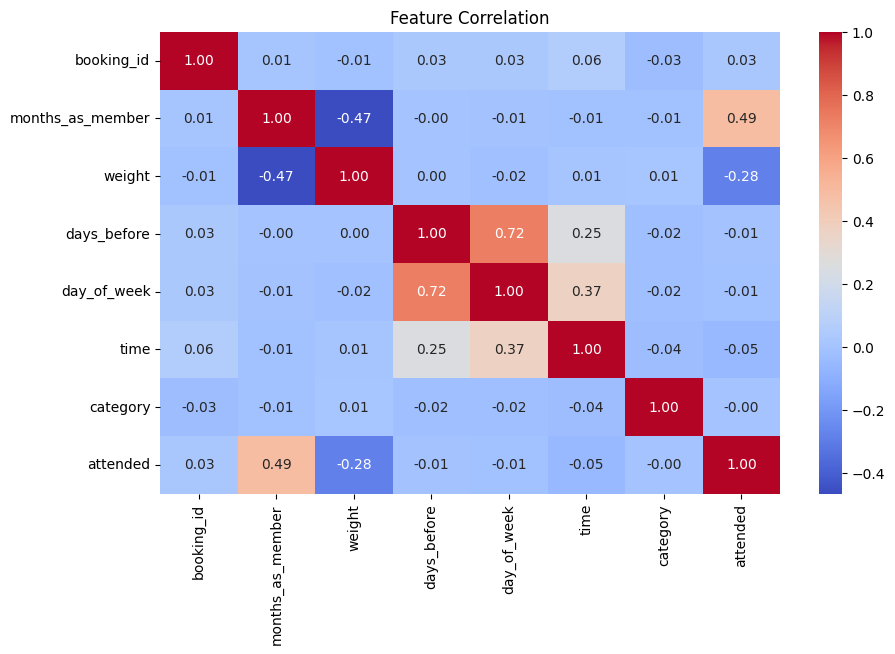

In [39]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

The booking_id should have no impact on the result of the attended variable. 

### Split Features and Test-train split

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest( score_func=f_classif, k=5)

# Split features and target
X = df.drop(['booking_id','attended'], axis=1)  # Replace 'Attendance' with your target column name
y = df['attended']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Scaling Data

In [41]:
# Feature scaling using standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Balancing Dataset

In [42]:
# Check for balance 
target_column = 'attended'
print('Number of samples in each class:')
df[target_column].value_counts()

Number of samples in each class:


attended
0    1046
1     454
Name: count, dtype: int64

In [43]:
# Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


### Logistic Regression

In [44]:
#Logistic Regression
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

print("\nLogistic Regression Performance (With Balancing):")
print(classification_report(y_test, y_pred_lr_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_balanced))


Logistic Regression Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       293
           1       0.66      0.67      0.66       157

    accuracy                           0.76       450
   macro avg       0.74      0.74      0.74       450
weighted avg       0.77      0.76      0.76       450

Confusion Matrix:
[[239  54]
 [ 52 105]]


In [45]:
#Hyperparameter Tuning (Logistic Regression)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization (l1 for Lasso, l2 for Ridge)
    'solver': ['liblinear', 'saga']  # solvers that support l1 and l2 penalties

}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Evaluate tuned Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)

metrics = []

def Append_Metrics(metric_holder,model_name,y_pred):
  metric_holder.append({
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test,y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            })


Append_Metrics(metrics,'Logistic_Regression',y_pred_best_lr)

print("\nTuned Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_best_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))

print(metrics)


Best Parameters for Logistic Regression:
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Tuned Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       293
           1       0.65      0.69      0.67       157

    accuracy                           0.76       450
   macro avg       0.74      0.74      0.74       450
weighted avg       0.77      0.76      0.76       450

Confusion Matrix:
[[235  58]
 [ 49 108]]
[{'Model': 'Logistic_Regression', 'Accuracy': 0.7622222222222222, 'Precision': 0.6506024096385542, 'Recall': 0.6878980891719745, 'F1': 0.6687306501547987}]


In [46]:
#Cross-Validation (Logistic Regression)
cv_scores_lr = cross_val_score(best_lr, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Mean CV Accuracy:", cv_scores_lr.mean())


Logistic Regression Cross-Validation Scores: [0.77483444 0.72757475 0.74086379 0.7641196  0.73754153]
Mean CV Accuracy: 0.7489868209720358


### Random Forest

In [47]:
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_balanced.predict(X_test_scaled)

print("\nRandom Forest Performance (With Balancing):")
print(classification_report(y_test, y_pred_rf_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))


Random Forest Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       293
           1       0.63      0.57      0.60       157

    accuracy                           0.73       450
   macro avg       0.71      0.70      0.70       450
weighted avg       0.73      0.73      0.73       450

Confusion Matrix:
[[240  53]
 [ 67  90]]


In [48]:
#Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate tuned Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

Append_Metrics(metrics,'Random_Forest',y_pred_best_rf)

print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       293
           1       0.62      0.58      0.60       157

    accuracy                           0.73       450
   macro avg       0.70      0.70      0.70       450
weighted avg       0.73      0.73      0.73       450

Confusion Matrix:
[[238  55]
 [ 66  91]]


In [49]:
#Cross-Validation (Random Forest)
cv_scores_rf = cross_val_score(best_rf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())


Random Forest Cross-Validation Scores: [0.78807947 0.75083056 0.84385382 0.84385382 0.87043189]
Mean CV Accuracy: 0.8194099139732899


### Gradient Boosting Trees (GBT)

In [50]:
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train_balanced, y_train_balanced)
y_pred_gbt = gbt.predict(X_test_scaled)

print("\nGradient Boosting Trees Performance:")
print(classification_report(y_test, y_pred_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbt))


Gradient Boosting Trees Performance:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       293
           1       0.65      0.63      0.64       157

    accuracy                           0.75       450
   macro avg       0.73      0.72      0.72       450
weighted avg       0.75      0.75      0.75       450

Confusion Matrix:
[[239  54]
 [ 58  99]]


In [51]:
#Hyperparameter Tuning (Gradient Boosting Trees)
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_gbt = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbt, cv=5)
grid_search_gbt.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Gradient Boosting Trees:")
print(grid_search_gbt.best_params_)

# Evaluate tuned Gradient Boosting Trees
best_gbt = grid_search_gbt.best_estimator_
y_pred_best_gbt = best_gbt.predict(X_test_scaled)

Append_Metrics(metrics,'Gradient Boosting Trees',y_pred_best_gbt)
metrics_df = pd.DataFrame(metrics)   # Create a Dataframe of the metrics of the models

print("\nTuned Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_best_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_gbt))


Best Parameters for Gradient Boosting Trees:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Tuned Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       293
           1       0.59      0.50      0.54       157

    accuracy                           0.70       450
   macro avg       0.67      0.65      0.66       450
weighted avg       0.69      0.70      0.70       450

Confusion Matrix:
[[238  55]
 [ 79  78]]


In [52]:
#Cross-Validation (Random Forest)
cv_scores_gbt = cross_val_score(best_gbt, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nGradient Boosting Trees Cross-Validation Scores:", cv_scores_gbt)
print("Mean CV Accuracy:", cv_scores_gbt.mean())


Gradient Boosting Trees Cross-Validation Scores: [0.71523179 0.70099668 0.85049834 0.85714286 0.89368771]
Mean CV Accuracy: 0.8035114738949638


### Comparing Model Performance

#### Confusion Matrices

Text(0.5, 1.0, 'Gradient Boosting Trees')

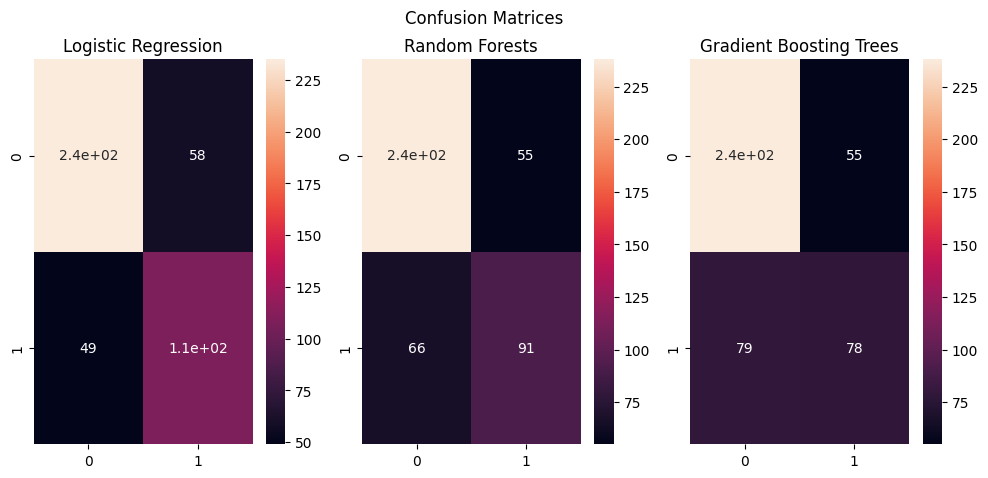

In [53]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
fig.suptitle('Confusion Matrices')

# Logistic Regression
cm = confusion_matrix(y_test,y_pred_best_lr)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Logistic Regression')

# Random Forests
cm = confusion_matrix(y_test,y_pred_best_rf)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Random Forests')

# Gradient Boosting Trees
cm = confusion_matrix(y_test,y_pred_best_gbt)
sns.heatmap(cm,annot=True, ax=ax3)
ax3.set_title('Gradient Boosting Trees')

### Barchart

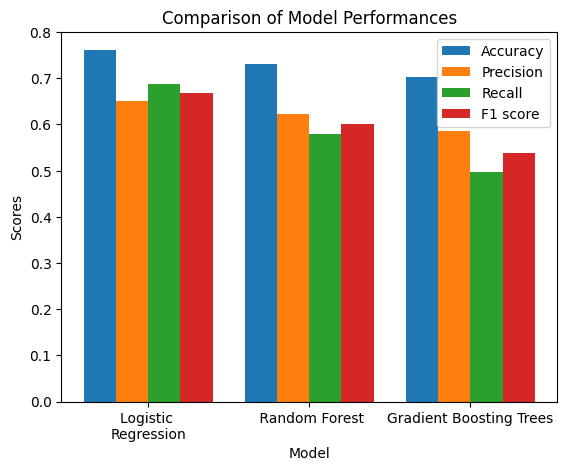

In [54]:
# Bar Chart of Performance Metrics
positions = np.arange(len(metrics_df))
bar_width = 0.2  # Reduced width to fit 4 bars


# Plot bars with appropriate spacing
plt.bar(positions - 1.5 * bar_width, metrics_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(positions - 0.5 * bar_width, metrics_df['Precision'], width=bar_width, label='Precision')
plt.bar(positions + 0.5 * bar_width, metrics_df['Recall'], width=bar_width, label='Recall')
plt.bar(positions + 1.5 * bar_width, metrics_df['F1'], width=bar_width, label='F1 score')


# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Model Performances')

# Adding legend and xticks
plt.legend()
plt.xticks(positions, ['Logistic \nRegression', ' Random Forest', 'Gradient Boosting Trees'])
plt.show()

### Bias-Variance Tradeoff (Learning Curves)

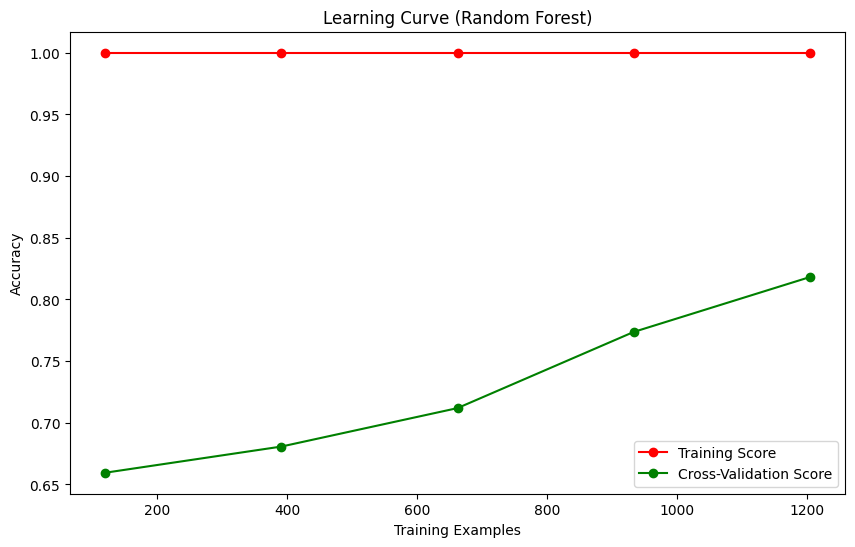

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\ensemble\_gb.py", line 665, in fit
    y = self._encode_y(y=y, sample_weight=None)
        ^^^^^^^^^^^^^^^^^^^

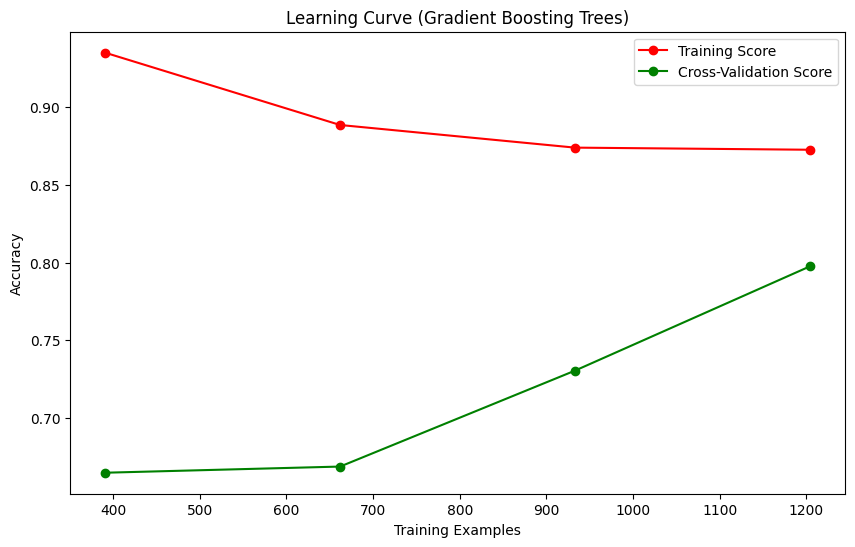

In [55]:
from sklearn.model_selection import learning_curve

# Function to plot the learning curve for the input estimator
def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train_balanced, y_train_balanced)

# Plot learning curve for Gradient Boosting Trees
plot_learning_curve(gbt, "Learning Curve (Gradient Boosting Trees)", X_train_balanced, y_train_balanced)
